# Perform single-cell quality control

In this notebook, we perform single-cell quality control using coSMicQC. 
We filter the single cells by identifying outliers with z-scores, and use either combinations of features or one feature for each condition. 
We use the feature(s) below to assess the technical quality of the segmented single-cells:

### Assessing poor nuclei segmentation

To identify nuclei segmentations that include multiple nuclei, we use the following feature as one condition:

- **Nuclei Solidity:** This metric quantifies how irregularly shaped a nuclei segmentation is. A value of 1 indicates that the segmentation is perfectly round and lower values indicate a very irregularly shaped nuclei (e.g., lot of indentation or protrusions).

To identify nuclei segmentations where the respective nuclei is over-saturated, we use the following feature as another condition.

- **Nuclei Mean Intensity:** This metric quantifies the average intensity of all pixels in a nuclei segmentation. Higher values mean that the pixels tend to be more intense, resulting in a blow-out or over-saturated nuclei, which can sometimes because of the staining.

## Import libraries

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from cosmicqc import find_outliers

## Define helper function

In [2]:
def reshape_data(df: pd.DataFrame, feature_col: str, feature_name: str) -> pd.DataFrame:
    """Reshape the data for generating plot for each quality control feature

    Args:
        df (pd.DataFrame): dataframe that will be reshaped for plotting
        feature_col (str): feature column with CP format to rename
        feature_name (str): renamed column

    Returns:
        pd.DataFrame: reshaped dataframe to use for plotting
    """
    return df[["Image_Metadata_Plate", feature_col, "Dataset"]].rename(
        columns={feature_col: "Value"}
    ).assign(Feature=feature_name)

## Set paths and variables

In [3]:
# Directory with data
data_dir = pathlib.Path("./data/converted_data/").resolve(strict=True)

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Metadata_Nuclei_Location_Center_X",
    "Metadata_Nuclei_Location_Center_Y",
]

# Path to dictionary
dictionary_path = pathlib.Path("./plate_info_dictionary.yaml")


## Load in dictionary of plates to process

In [4]:
# Load plate information from YAML file
with open(dictionary_path, "r") as file:
    plate_info = yaml.safe_load(file)

# Load in specific plates relevant to manuscript
plates = ["Plate_3_prime", "Plate_3", "Plate_5", "Plate_6"]

# Load in specified plates from plate_info_dictionary
plates = plate_info.keys()
dfs = {plate: pd.read_parquet(plate_info[plate]['dest_path']) for plate in plates}

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs.values(), ignore_index=True)

# Print output
print(combined_df.shape)
combined_df.head()


(40480, 2317)


,Metadata_ImageNumber,Image_Metadata_Plate,Metadata_number_of_singlecells,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Image_FileName_CY5,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,2,Plate_3,84,11,B10,1,1,2,2,B10_01_3_11_CY5_001_illumcorrect.tiff,...,3103.378595,2928.440215,1289.387179,1113.191261,1143.798104,1229.706291,1860.427125,1792.018063,1751.963638,1860.317249
1,5,Plate_3,84,14,B10,1,1,2,2,B10_01_3_14_CY5_001_illumcorrect.tiff,...,674.346209,687.648994,38.764372,40.170070,40.270733,37.789788,101.849116,99.378570,99.875012,98.784846
2,12,Plate_3,84,20,B10,1,1,2,2,B10_01_3_20_CY5_001_illumcorrect.tiff,...,1566.205750,1486.305372,279.656989,270.323458,300.199086,289.428542,189.134603,192.120194,188.116851,187.663065
3,13,Plate_3,84,21,B10,1,1,2,2,B10_01_3_21_CY5_001_illumcorrect.tiff,...,544.841379,546.635939,35.728497,37.452466,34.925836,34.609601,84.199793,86.931665,85.634432,82.349088
4,14,Plate_3,84,22,B10,1,1,2,2,B10_01_3_22_CY5_001_illumcorrect.tiff,...,1001.824339,979.699936,85.783028,82.215142,84.944425,100.984105,226.980762,230.125834,230.609025,226.963522


## Over-saturated nuclei (mitosis/debris)

In [5]:
# Set outlier threshold that maximizes removing most technical outliers and minimizes good cells
outlier_threshold = 2

# find nuclei with overly high intensity (over-saturated)
feature_thresholds = {
    "Nuclei_Intensity_MeanIntensity_DAPI": outlier_threshold,
}

nuclei_high_int_outliers = find_outliers(
    df=combined_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds
)

# Sort the outliers by Nuclei_AreaShape_Area
nuclei_high_int_outliers = nuclei_high_int_outliers.sort_values(by="Nuclei_Intensity_MeanIntensity_DAPI", ascending=True)

print(nuclei_high_int_outliers.shape)
nuclei_high_int_outliers.head()

Number of outliers: 1099 (2.71%)
Outliers Range:
Nuclei_Intensity_MeanIntensity_DAPI Min: 0.7873540010431148
Nuclei_Intensity_MeanIntensity_DAPI Max: 0.889851374585373
(1099, 6)


,Nuclei_Intensity_MeanIntensity_DAPI,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
8563,0.787354,Plate_3,D4,23,998.584718,589.620155
11232,0.787371,Plate_3,E6,5,788.285282,380.350806
35293,0.787439,Plate_6,D4,29,1030.062921,387.594007
38384,0.787463,Plate_6,F4,2,781.818776,439.988072
38419,0.787465,Plate_6,F4,1,675.755061,683.151344


In [6]:
# Print out the number of outliers across plates
outlier_counts = nuclei_high_int_outliers['Image_Metadata_Plate'].value_counts()

# Calculate the percentage of outliers
total_counts = combined_df['Image_Metadata_Plate'].value_counts()
outlier_percentages = (outlier_counts / total_counts) * 100

# Print the counts and percentages
for plate, count in outlier_counts.items():
    print(f"{plate}: {count} outliers ({outlier_percentages[plate]:.2f}%)")

Plate_3: 607 outliers (3.37%)
Plate_3_prime: 336 outliers (4.60%)
Plate_6: 143 outliers (1.94%)
Plate_5: 13 outliers (0.17%)


## Over-segmented nuclei (reflected by irregular, non-circular shape)

In [7]:
# Set outlier threshold that maximizes removing most technical outliers and minimizes good cells
outlier_threshold = -1.5

# find irregular shaped nuclei
feature_thresholds = {
    "Nuclei_AreaShape_Solidity": outlier_threshold,
}

irregular_nuclei_outliers = find_outliers(
    df=combined_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds
)

print(irregular_nuclei_outliers.shape)
irregular_nuclei_outliers.sort_values(by="Nuclei_AreaShape_Solidity", ascending=True).head()

Number of outliers: 2002 (4.95%)
Outliers Range:
Nuclei_AreaShape_Solidity Min: 0.42840844266970907
Nuclei_AreaShape_Solidity Max: 0.9326328800988876
(2002, 6)


,Nuclei_AreaShape_Solidity,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
18590,0.428408,Plate_3_prime,B5,17,453.272969,272.933422
17870,0.431098,Plate_3,E9,18,396.416031,286.857347
21543,0.432432,Plate_3_prime,F9,7,509.310185,389.790509
18608,0.465046,Plate_3_prime,B5,17,397.563399,858.516340
17878,0.503407,Plate_3,E9,18,1040.443963,276.983216


In [8]:
filtered_outliers = irregular_nuclei_outliers[
    (irregular_nuclei_outliers["Image_Metadata_Plate"] == "Plate_3_prime") &
    (irregular_nuclei_outliers["Image_Metadata_Well"] == "B5") &
    (irregular_nuclei_outliers["Image_Metadata_Site"] == '17')
]

print(filtered_outliers.shape)
filtered_outliers.head()


(2, 6)


,Nuclei_AreaShape_Solidity,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
18590,0.428408,Plate_3_prime,B5,17,453.272969,272.933422
18608,0.465046,Plate_3_prime,B5,17,397.563399,858.516340


In [9]:
# Print out the number of outliers across plates
outlier_counts = irregular_nuclei_outliers['Image_Metadata_Plate'].value_counts()

# Calculate the percentage of outliers
total_counts = combined_df['Image_Metadata_Plate'].value_counts()
outlier_percentages = (outlier_counts / total_counts) * 100

# Print the counts and percentages
for plate, count in outlier_counts.items():
    print(f"{plate}: {count} outliers ({outlier_percentages[plate]:.2f}%)")

Plate_3: 909 outliers (5.04%)
Plate_6: 445 outliers (6.03%)
Plate_5: 432 outliers (5.57%)
Plate_3_prime: 216 outliers (2.96%)


In [10]:
# Remove outliers from combined_df
outlier_indices = nuclei_high_int_outliers.index.union(irregular_nuclei_outliers.index)
filtered_combined_df = combined_df.drop(outlier_indices)
print(filtered_combined_df.shape[0])

37455


## Generate plot

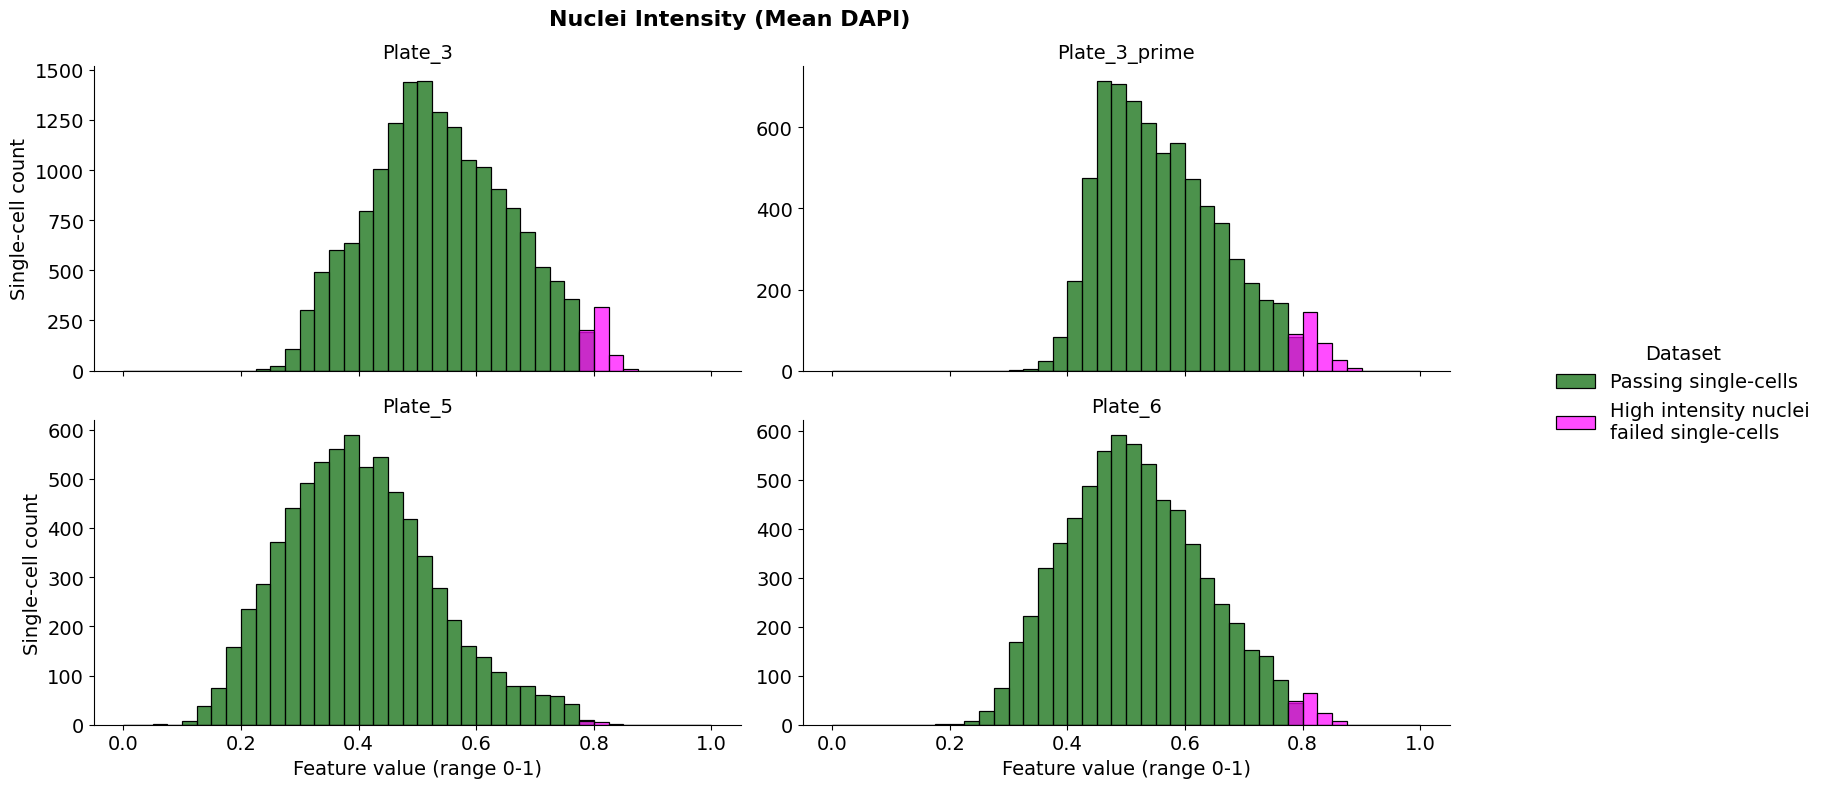

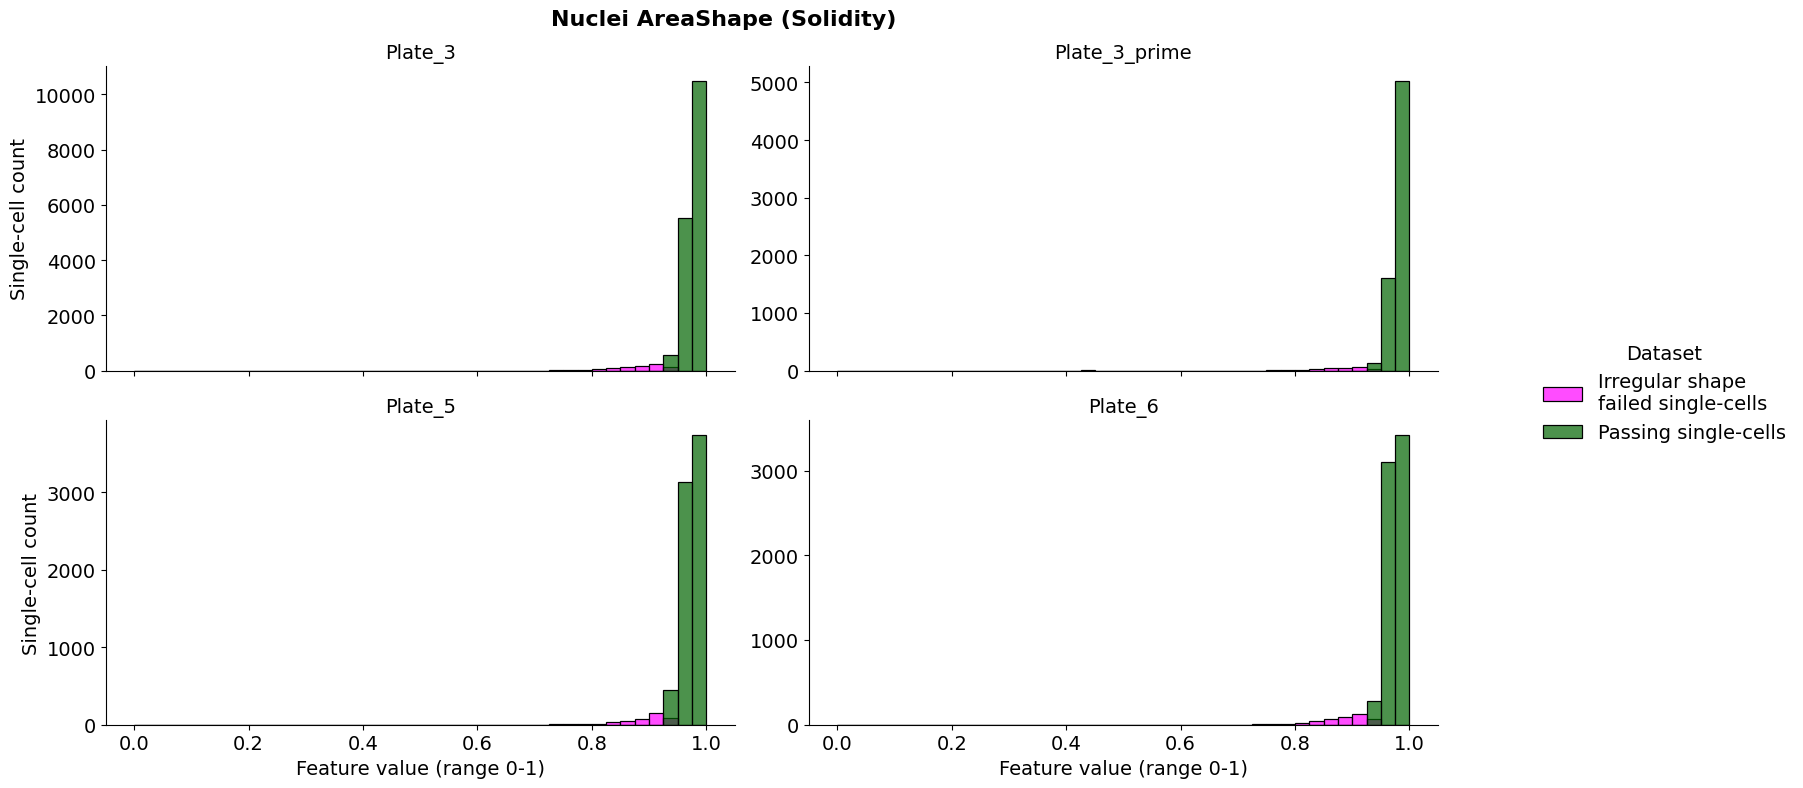

In [11]:
# Set palette for plot
palette = {
    "Passing single-cells": "darkgreen",
    "High intensity nuclei\nfailed single-cells": "magenta",
    "Irregular shape\nfailed single-cells": "magenta",
}

# Add dataset labels
for df, label in [
    (filtered_combined_df, "Passing single-cells"),
    (nuclei_high_int_outliers, "High intensity nuclei\nfailed single-cells"),
    (irregular_nuclei_outliers, "Irregular shape\nfailed single-cells"),
]:
    df["Dataset"] = label

plot_df = pd.concat([
    reshape_data(filtered_combined_df, "Nuclei_Intensity_MeanIntensity_DAPI", "Nuclei Intensity (Mean DAPI)"),
    reshape_data(nuclei_high_int_outliers, "Nuclei_Intensity_MeanIntensity_DAPI", "Nuclei Intensity (Mean DAPI)"),
    reshape_data(irregular_nuclei_outliers, "Nuclei_AreaShape_Solidity", "Nuclei AreaShape (Solidity)"),
    reshape_data(filtered_combined_df, "Nuclei_AreaShape_Solidity", "Nuclei AreaShape (Solidity)"),
])

# Create FacetGrid with 2x2 layout per feature
for feature in plot_df["Feature"].unique():
    feature_df = plot_df[plot_df["Feature"] == feature]  # Subset data

    g = sns.FacetGrid(
        feature_df,
        col="Image_Metadata_Plate",
        hue="Dataset",
        palette=palette,
        height=4,
        aspect=1.5,
        sharex=True,
        sharey=False,
        col_wrap=2  # Ensures 2x2 layout
    )

    # Plot histograms with dodged bars
    g.map(sns.histplot, "Value", bins=40, binrange=(0, 1), alpha=0.7, edgecolor="black", multiple="dodge")

    # Customize labels and titles
    g.set_xlabels("Feature value (range 0-1)", fontsize=14)
    g.set_ylabels("Single-cell count", fontsize=14)
    g.set_titles(col_template="{col_name}", size=14)
    # Adjust tick labels size
    for ax in g.axes.flat:
        ax.tick_params(labelsize=14)

    # Add the legend
    g.add_legend(title="Dataset", bbox_to_anchor=(1.05, 0.5), loc="center left", prop={"size": 14})

    # Retrieve the legend object
    legend = g._legend  # Access the legend from the FacetGrid

    # Adjust the legend title font size
    legend.set_title("Dataset")
    legend.get_title().set_fontsize(14)


    # Add a suptitle for the feature
    g.figure.suptitle(feature, fontsize=16, fontweight="bold")
    g.figure.subplots_adjust(top=0.85)  # Adjust spacing for title

    if feature == "Nuclei Intensity (Mean DAPI)":
        feature = "nuclei_int_dapi"
    else:
        feature = "nuclei_solidity"

    plt.tight_layout()
    g.savefig(f"{qc_fig_dir}/cosmicqc_distribution_{feature}.png", dpi=500)


In [12]:
# Collect the indices of the outliers
outlier_indices = pd.concat([nuclei_high_int_outliers, irregular_nuclei_outliers]).index

# Remove rows with outlier indices from combined_df
combined_df_cleaned = combined_df.drop(outlier_indices)

# Save cleaned data for each plate and update the dictionary with cleaned paths
for plate in plates:
    plate_df_cleaned = combined_df_cleaned[combined_df_cleaned['Image_Metadata_Plate'] == plate]
    cleaned_path = f"{cleaned_dir}/{plate}_cleaned.parquet"
    plate_df_cleaned.to_parquet(cleaned_path)
    plate_info[plate]['cleaned_path'] = cleaned_path
    print(plate, ":", plate_df_cleaned.shape)

# Print the number of outliers removed and percentage from the total per plate
for plate in plates:
    original_count = total_counts[plate]
    outlier_count = outlier_counts.get(plate, 0)
    percentage_removed = outlier_percentages.get(plate, 0)
    print(f"{plate}: {outlier_count} outliers removed ({percentage_removed:.2f}%) from {original_count} total cells")

Plate_3 : (16574, 2317)
Plate_3_prime : (6766, 2317)
Plate_5 : (7315, 2317)
Plate_6 : (6800, 2317)
Plate_3: 909 outliers removed (5.04%) from 18038 total cells
Plate_3_prime: 216 outliers removed (2.96%) from 7300 total cells
Plate_5: 432 outliers removed (5.57%) from 7759 total cells
Plate_6: 445 outliers removed (6.03%) from 7383 total cells


## Dump the new cleaned path to the dictionary for downstream processing

In [13]:
with open(dictionary_path, "w") as file:
    yaml.dump(plate_info, file)